# Reinforcement learning with OpenAI gym and Keras

You can find a list of gym environments here: https://gym.openai.com/envs/#atari,  
and a documentation of the methods here: https://gym.openai.com/docs/

The example is based on https://github.com/taylormcnally/keras-rl2/blob/master/examples/dqn_cartpole.py

You can find the keras RL documentation here: https://keras-rl.readthedocs.io/en/latest/agents/overview/

In [1]:
import numpy as np
import gym

from keras.models import Model
from keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy  # https://github.com/keras-rl/keras-rl/blob/master/rl/policy.py
from rl.memory import SequentialMemory
from rl.callbacks import ModelIntervalCheckpoint, FileLogger

In cartpole, we try to balance a pole on a cart as long as possible. The pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 

The inputs (state) the agent gets are: 
- the position of the cart
- the velocity of the cart
- the angle of the pole
- and the rotational rate of the pole 

To keep the pole in balance the agent can apply a force of 0 (push cart to the left) or +1 (push cart to the right). A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or when the cart moves more than 4.8 units from the center.

The goal is to get an average reward of 195.0 over 100 consecutive trials.

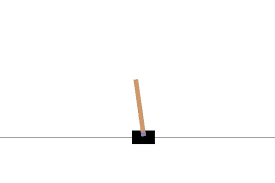

Information about observation space and action space can be found [here](https://github.com/openai/gym/wiki/CartPole-v0)

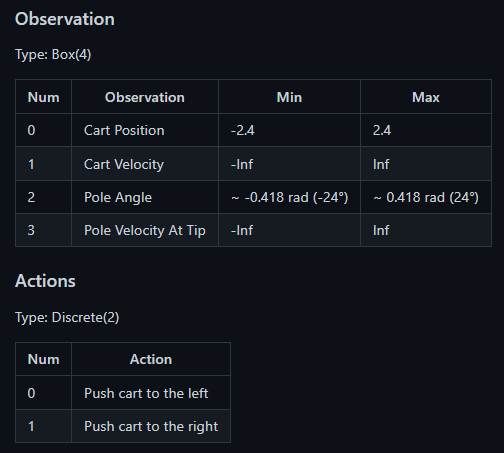

In [ ]:
# this code is only meant to take a look at the environment
# print the observation (state) and action space
env = gym.make('CartPole-v0')  # setup a Cartpole environment
print(env.observation_space)
print(env.action_space)


## Deep Q-networks

To solve the cartpole problem, we will use $Q$ learning, to learn the action value function $Q(s,a)$. That is, we want our agent to learn what is the best action given the state we are currently in. E.g. given a certain cart position and velocitiy and pole angle and velocity, should the agent push the cart to the left or to the right?

We can iteratively approximate the ideal $Q(s,a)$ using the Bellman equation: $Q(s,a) = R + \gamma max_a Q(s', a)$, where $R$ is the action's reward, $max_a Q(s', a)$ determines the action with the highest action value of the next state and $0 \le \gamma \le 1$ is the discount rate.

As shown in the image, we will use an $\epsilon$-greedy policy, where we will choose the best action with $1-\greedy$ probability and a random action with $\epsilon$ probability. 

Note that an *off-policy* agent always updates the Q values of the greedy action, even if a non-greedy action was chosen. We have already seen this in the first RL lecture (tic-tac-toe example). An *on-policy* algorithm (e.g. SARSA) would update the Q-values based on the current (non-greedy) policy. 

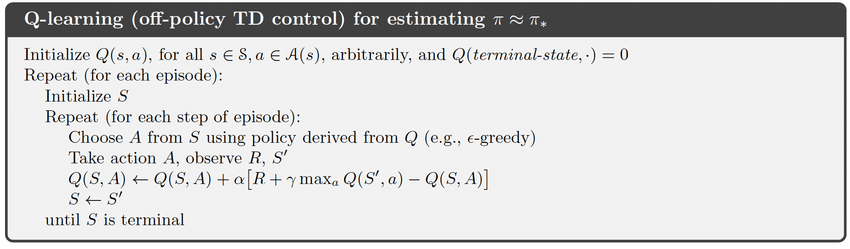

To use the recursive Bellman equation, we would have to keep a matrix of experienced rewards for every state and action. However, the cartpole environment, and many others, have a very large (infinite) state space with continuous variables such as the velocity, which renders keeping a basically infinite matrix impossible. 

Therefore, we approximate the $Q$ function using a neural network. Remember that neural networks are basically function approximators and are thus perfectly suited for the job. Here, the network learns to map states to actions and thereby estimate the state value $Q(s,a)$ to output the maximum $Q(s,a)$.



In [2]:
# setting up the neural network

def build_model(state_size, num_actions):
    input = Input(shape=(1, state_size))  # state size is the observation space, so it's (1,4)
    x = Flatten()(input)
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    output = Dense(num_actions, activation='linear')(x)  # one output for each possible action
    model = Model(inputs=input, outputs=output)
    return model

In [6]:
    env = gym.make('CartPole-v0')  
    np.random.seed(42)
    env.seed(42)

    num_actions = env.action_space.n  # number of actions in the environment (2)
    state_space = env.observation_space.shape[0]  # shape of the observation space
    print(f'Number of actions: {num_actions}, state space: {state_space}')

    model = build_model(state_space, num_actions)  # get the network

    # memory: store a number of experiences and sample a random set to learn from
    # if the limit size is exceeded old memories are forgotten
    # https://deeplizard.com/learn/video/Bcuj2fTH4_4
    memory = SequentialMemory(limit=50000, window_length=1) 
    
    # epsilon-greedy policy 
    # linear annealing will decrease epsilon every run
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                                  nb_steps=10000)
    
    # nb_steps_warmup: how long to wait until sampling from memory (and actually training the network)
    # if nb_steps_warmup is smaller than the memory size, keras samples with replacements
    # target_model_update: guarantees stability (remember that we are training a network and thus all parameters at once)
    # see also: https://stackoverflow.com/questions/54237327/why-is-a-target-network-required
    dqn = DQNAgent(model=model, nb_actions=num_actions, memory=memory, nb_steps_warmup=1000,
                   target_model_update=1e-2, policy=policy)
    
    dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
    dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)  # use verbose=0 to surpress outputs and increase trainin speed
    # 'visualise' visualises the agent in the environment which distinctively slows down training 

    # save the final weights
    dqn.save_weights('dqn_cartpole_weights.h5f', overwrite=True)


Number of actions: 2, state space: 4
Training for 50000 steps ...
    29/50000: episode: 1, duration: 0.157s, episode steps:  29, steps per second: 185, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.586 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    37/50000: episode: 2, duration: 0.009s, episode steps:   8, steps per second: 888, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 1.000 [1.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    67/50000: episode: 3, duration: 0.031s, episode steps:  30, steps per second: 960, episode reward: 30.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.433 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --


C:\Users\m.stern\AppData\Local\Continuum\anaconda3\envs\oth\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    85/50000: episode: 4, duration: 0.034s, episode steps:  18, steps per second: 529, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.556 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   106/50000: episode: 5, duration: 0.025s, episode steps:  21, steps per second: 843, episode reward: 21.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.524 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   115/50000: episode: 6, duration: 0.010s, episode steps:   9, steps per second: 883, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.778 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   137/50000: episode: 7, duration: 0.022s, episode steps:  22, steps per second: 993, episode reward: 22.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.455 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   166/50000: episode: 8, duration: 0.028s, episode steps:  29, steps per second: 10

   999/50000: episode: 42, duration: 0.031s, episode steps:  29, steps per second: 936, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.448 [0.000, 1.000],  loss: --, mae: --, mean_q: --, mean_eps: --


C:\Users\m.stern\AppData\Local\Continuum\anaconda3\envs\oth\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  1032/50000: episode: 43, duration: 1.234s, episode steps:  33, steps per second:  27, episode reward: 33.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 0.456746, mae: 0.513904, mean_q: 0.096605, mean_eps: 0.908560
  1045/50000: episode: 44, duration: 0.130s, episode steps:  13, steps per second: 100, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 0.337119, mae: 0.519344, mean_q: 0.256743, mean_eps: 0.906580
  1064/50000: episode: 45, duration: 0.210s, episode steps:  19, steps per second:  90, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.474 [0.000, 1.000],  loss: 0.238338, mae: 0.538974, mean_q: 0.444632, mean_eps: 0.905140
  1077/50000: episode: 46, duration: 0.112s, episode steps:  13, steps per second: 117, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.692 [0.000, 1.000],  loss: 0.144211, mae: 0.574449, mean_q: 0.693620, mea

  2007/50000: episode: 76, duration: 0.261s, episode steps:  32, steps per second: 123, episode reward: 32.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.444368, mae: 4.155072, mean_q: 8.078196, mean_eps: 0.820855
  2036/50000: episode: 77, duration: 0.235s, episode steps:  29, steps per second: 123, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.517 [0.000, 1.000],  loss: 0.458286, mae: 4.260414, mean_q: 8.299371, mean_eps: 0.818110
  2073/50000: episode: 78, duration: 0.303s, episode steps:  37, steps per second: 122, episode reward: 37.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.541 [0.000, 1.000],  loss: 0.553147, mae: 4.386168, mean_q: 8.544479, mean_eps: 0.815140
  2119/50000: episode: 79, duration: 0.370s, episode steps:  46, steps per second: 124, episode reward: 46.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.543 [0.000, 1.000],  loss: 0.508942, mae: 4.553612, mean_q: 8.913664, mea

  3256/50000: episode: 109, duration: 0.747s, episode steps:  94, steps per second: 126, episode reward: 94.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.468 [0.000, 1.000],  loss: 0.987609, mae: 9.053827, mean_q: 18.263608, mean_eps: 0.711235
  3276/50000: episode: 110, duration: 0.165s, episode steps:  20, steps per second: 121, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 0.532125, mae: 9.301054, mean_q: 18.822968, mean_eps: 0.706105
  3329/50000: episode: 111, duration: 0.434s, episode steps:  53, steps per second: 122, episode reward: 53.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.509 [0.000, 1.000],  loss: 0.790951, mae: 9.448854, mean_q: 19.204386, mean_eps: 0.702820
  3347/50000: episode: 112, duration: 0.148s, episode steps:  18, steps per second: 122, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.389 [0.000, 1.000],  loss: 0.918476, mae: 9.510683, mean_q: 19.343

  6142/50000: episode: 141, duration: 1.316s, episode steps: 166, steps per second: 126, episode reward: 166.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.518 [0.000, 1.000],  loss: 3.949828, mae: 23.827301, mean_q: 48.844024, mean_eps: 0.454735
  6297/50000: episode: 142, duration: 1.281s, episode steps: 155, steps per second: 121, episode reward: 155.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.471 [0.000, 1.000],  loss: 4.054445, mae: 24.752826, mean_q: 50.652762, mean_eps: 0.440290
  6321/50000: episode: 143, duration: 0.200s, episode steps:  24, steps per second: 120, episode reward: 24.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 2.287316, mae: 25.231396, mean_q: 52.019032, mean_eps: 0.432235
  6341/50000: episode: 144, duration: 0.168s, episode steps:  20, steps per second: 119, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.550 [0.000, 1.000],  loss: 5.188535, mae: 25.493725, mean_q: 

 11664/50000: episode: 173, duration: 2.979s, episode steps: 200, steps per second:  67, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.455712, mae: 46.116882, mean_q: 93.246534, mean_eps: 0.100000
 11864/50000: episode: 174, duration: 1.775s, episode steps: 200, steps per second: 113, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 11.597591, mae: 46.622592, mean_q: 94.403840, mean_eps: 0.100000
 12064/50000: episode: 175, duration: 1.875s, episode steps: 200, steps per second: 107, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 13.538125, mae: 46.760606, mean_q: 94.771669, mean_eps: 0.100000
 12264/50000: episode: 176, duration: 2.218s, episode steps: 200, steps per second:  90, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 14.454511, mae: 47.418047, me

 17948/50000: episode: 205, duration: 2.486s, episode steps: 200, steps per second:  80, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.495 [0.000, 1.000],  loss: 18.287839, mae: 58.258992, mean_q: 117.514721, mean_eps: 0.100000
 18148/50000: episode: 206, duration: 1.788s, episode steps: 200, steps per second: 112, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 17.887515, mae: 58.353626, mean_q: 117.691763, mean_eps: 0.100000
 18348/50000: episode: 207, duration: 1.836s, episode steps: 200, steps per second: 109, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 20.275956, mae: 58.518029, mean_q: 118.049237, mean_eps: 0.100000
 18548/50000: episode: 208, duration: 1.893s, episode steps: 200, steps per second: 106, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 23.505644, mae: 58.231885,

 24348/50000: episode: 237, duration: 2.170s, episode steps: 200, steps per second:  92, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 22.964820, mae: 61.694816, mean_q: 124.347973, mean_eps: 0.100000
 24548/50000: episode: 238, duration: 1.773s, episode steps: 200, steps per second: 113, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 28.350063, mae: 62.192023, mean_q: 125.332937, mean_eps: 0.100000
 24748/50000: episode: 239, duration: 3.261s, episode steps: 200, steps per second:  61, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 27.578013, mae: 62.439891, mean_q: 125.580486, mean_eps: 0.100000
 24948/50000: episode: 240, duration: 2.227s, episode steps: 200, steps per second:  90, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.515 [0.000, 1.000],  loss: 32.437868, mae: 62.519732,

 30561/50000: episode: 269, duration: 1.856s, episode steps: 200, steps per second: 108, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.485 [0.000, 1.000],  loss: 19.034294, mae: 61.607512, mean_q: 123.874406, mean_eps: 0.100000
 30761/50000: episode: 270, duration: 1.951s, episode steps: 200, steps per second: 103, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.520 [0.000, 1.000],  loss: 24.940421, mae: 60.765951, mean_q: 121.983339, mean_eps: 0.100000
 30961/50000: episode: 271, duration: 1.752s, episode steps: 200, steps per second: 114, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.490 [0.000, 1.000],  loss: 21.439143, mae: 60.607677, mean_q: 121.604883, mean_eps: 0.100000
 31161/50000: episode: 272, duration: 1.759s, episode steps: 200, steps per second: 114, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.495 [0.000, 1.000],  loss: 25.069552, mae: 60.413681,

 36916/50000: episode: 301, duration: 1.703s, episode steps: 200, steps per second: 117, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 17.022316, mae: 53.243547, mean_q: 106.439273, mean_eps: 0.100000
 37116/50000: episode: 302, duration: 1.676s, episode steps: 200, steps per second: 119, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 14.690024, mae: 52.941018, mean_q: 106.038855, mean_eps: 0.100000
 37316/50000: episode: 303, duration: 1.708s, episode steps: 200, steps per second: 117, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 12.022260, mae: 52.743996, mean_q: 105.710333, mean_eps: 0.100000
 37437/50000: episode: 304, duration: 1.032s, episode steps: 121, steps per second: 117, episode reward: 121.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.504 [0.000, 1.000],  loss: 13.105339, mae: 52.352740,

 42954/50000: episode: 333, duration: 1.701s, episode steps: 200, steps per second: 118, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.495 [0.000, 1.000],  loss: 10.289098, mae: 49.223258, mean_q: 98.545503, mean_eps: 0.100000
 43154/50000: episode: 334, duration: 1.713s, episode steps: 200, steps per second: 117, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.505 [0.000, 1.000],  loss: 9.576053, mae: 49.114882, mean_q: 98.225340, mean_eps: 0.100000
 43354/50000: episode: 335, duration: 1.692s, episode steps: 200, steps per second: 118, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 13.806932, mae: 49.004576, mean_q: 97.979730, mean_eps: 0.100000
 43529/50000: episode: 336, duration: 1.486s, episode steps: 175, steps per second: 118, episode reward: 175.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.497 [0.000, 1.000],  loss: 10.851427, mae: 48.635036, mea

 48706/50000: episode: 365, duration: 2.053s, episode steps: 200, steps per second:  97, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 21.587274, mae: 59.772292, mean_q: 120.033870, mean_eps: 0.100000
 48906/50000: episode: 366, duration: 1.834s, episode steps: 200, steps per second: 109, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.480 [0.000, 1.000],  loss: 14.995989, mae: 59.907913, mean_q: 120.556234, mean_eps: 0.100000
 49017/50000: episode: 367, duration: 0.990s, episode steps: 111, steps per second: 112, episode reward: 111.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.523 [0.000, 1.000],  loss: 24.383587, mae: 60.778562, mean_q: 121.844460, mean_eps: 0.100000
 49217/50000: episode: 368, duration: 1.794s, episode steps: 200, steps per second: 111, episode reward: 200.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.510 [0.000, 1.000],  loss: 19.593554, mae: 60.912521,

In [4]:
# evaluate and visualise
dqn.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200


### Questions:
- Observe the training process, what can you spot regarding the number of warmup steps and the e-greedy policy?
- Try tweaking the hyperparameters, such as network architecture, epsilon values, target_model_update frequency, other policies (# https://github.com/keras-rl/keras-rl/blob/master/rl/policy.py), etc. What breaks the agent the most effectively?
- Try out another environment, e.g. lunar lander, does it work with your current setup? See https://github.com/PacktPublishing/Deep-Learning-Quick-Reference/blob/master/Chapter12/dqn_lunar_lander.py for a working network setup
